# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. Our model will be trained so that it embeds both images and texts into the same space, and importantly, maps relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function.<br>
<br>
In this note book, we investigate the effect of shuffling the negative pairs generation during the training.

## 1. Preparation
As always, prepare the dataset for the training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [ ]:
# Split them into training and test sets.
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
# These are the libraries we developed from scratch for this project.
sys.path.append("drive/My Drive/finalproj")
import EncoderHeads, Dataset, utils

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


In [ ]:
embed_dim = 256
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "InceptionV3"
text_encoder_model = "BERT"
image_head_model = "FC"
text_head_model = "FC"

TrainingDataset = Dataset.DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = Dataset.DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

100%|██████████| 99/99 [00:20<00:00,  4.89it/s]


Preprocessing text data...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 985/985 [00:45<00:00, 21.48it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:06<00:00,  7.15it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:19<00:00, 21.62it/s]


=== Image Encoder ===
  Pretrained Parameters: 25,112,264

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


## 2. Generating Negative Pairs in Each Epoch.
Hopefully, it makes our model more robust to unseen data.

In [ ]:
epochs = 20
batch_size = 128
train_loss = []
eval_loss = []
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

=== Image Encoder Head ===
  Trainable Parameters: 1,180,416

=== Text Encoder Head ===
  Trainable Parameters: 525,056


In [ ]:
print("Start Training...")
for epoch in range(epochs):
    trainloader.dataset.shuffle() # Do shuffling.
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
    train_loss.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
_, sim_mat = utils.eval(testloader, image_head, text_head, criterion, only_loss=False)

Start Training...
Epoch: 2 | Training loss: 0.1535 | Test loss: 0.1548
Epoch: 4 | Training loss: 0.0997 | Test loss: 0.1311
Epoch: 6 | Training loss: 0.0854 | Test loss: 0.1265
Epoch: 8 | Training loss: 0.0777 | Test loss: 0.1259
Epoch: 10 | Training loss: 0.0733 | Test loss: 0.1259
Epoch: 12 | Training loss: 0.0696 | Test loss: 0.1218
Epoch: 14 | Training loss: 0.0666 | Test loss: 0.1225
Epoch: 16 | Training loss: 0.0643 | Test loss: 0.1208
Epoch: 18 | Training loss: 0.0629 | Test loss: 0.1201
Epoch: 20 | Training loss: 0.0612 | Test loss: 0.1205


In [ ]:
shuffling_loss = {"training": train_loss, "test": eval_loss}
with open(f"drive/My Drive/finalproj/shuffling_loss.pkl", "wb") as f:
    pickle.dump(shuffling_loss, f)

In [ ]:
with open(f"drive/My Drive/finalproj/base_model_loss.pkl", "rb") as f:
    base_model_loss = pickle.load(f)

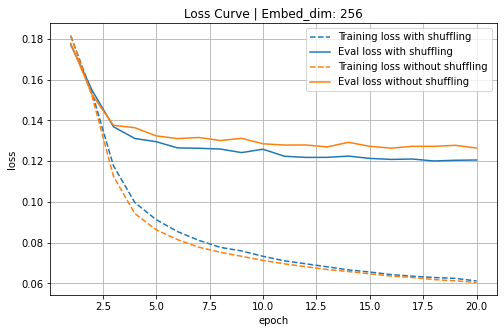

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs + 1), train_loss, label="Training loss with shuffling", color=plt.cm.tab10(0), linestyle="dashed")
plt.plot(np.arange(1, epochs + 1), eval_loss, label="Eval loss with shuffling", color=plt.cm.tab10(0))
plt.plot(np.arange(1, epochs + 1), base_model_loss["training"], label="Training loss without shuffling", color=plt.cm.tab10(1), linestyle="dashed")
plt.plot(np.arange(1, epochs + 1), base_model_loss["test"], label="Eval loss without shuffling", color=plt.cm.tab10(1))
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("shuffling.png", bbox_inches="tight")
plt.show()

## 3. Observation
As the loss curve shows, the training loss was increased a bit while the test loss was decreased as expected. We got a higher training loss because the model cannot overfit to fixed negative pairs. This improves the robustness of our model, resulting in better test loss.